In [114]:
!pip install numpy matplotlib pillow


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading image: ../posters/_97A2638.jpg
Image Size: (800, 533)
Loading noise: ..\bluenoise\128_128\LDR_LLL1_0.png


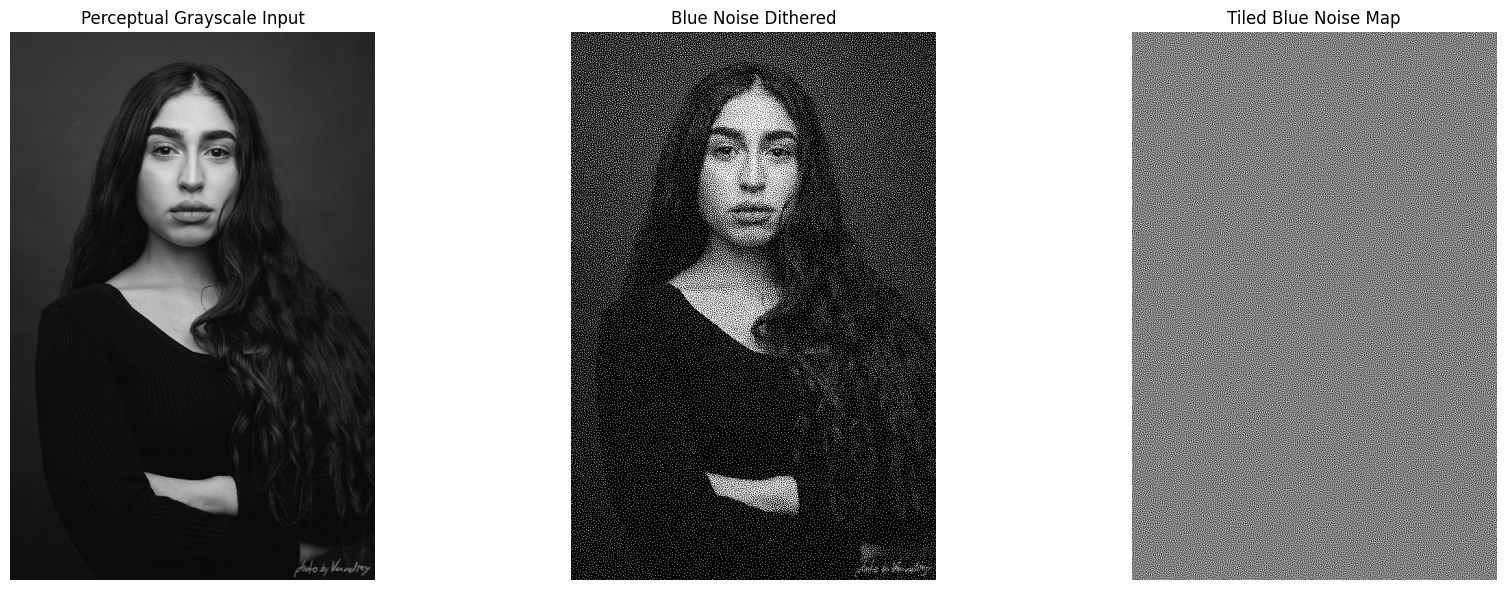

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# ==========================================
# 1. Configuration & Paths
# ==========================================
# Adjust these paths as needed
INPUT_IMAGE_PATH = "../posters/_97A2638.jpg"

# Using os.path.join for cross-platform compatibility (Windows/Mac/Linux)
# This matches your request: ..\bluenoise\128_128\LDR_LLL1_0.png
BLUE_NOISE_PATH = os.path.join('..', 'bluenoise', '128_128', 'LDR_LLL1_0.png')

# ==========================================
# 2. Helper Functions
# ==========================================

def load_and_normalize(path):
    """Loads an image, converts to float, normalizes to 0-1."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    
    img = Image.open(path)
    img = img.convert('RGB') # Ensure RGB
    return np.array(img).astype(np.float32) / 255.0

def rgb_to_grayscale_perceptual(img_rgb):
    """
    Converts RGB to Grayscale using Rec. 601 Luma coefficients.
    L = 0.299*R + 0.587*G + 0.114*B
    """
    # img_rgb shape is (H, W, 3)
    r = img_rgb[:, :, 0]
    g = img_rgb[:, :, 1]
    b = img_rgb[:, :, 2]
    
    gray = 0.299 * r + 0.587 * g + 0.114 * b
    return gray

def tile_noise(noise_texture, target_shape):
    """
    Tiles the noise texture to cover the target image shape.
    target_shape: (Height, Width)
    """
    th, tw = target_shape
    nh, nw = noise_texture.shape
    
    # Calculate how many times to repeat in Y and X
    repeat_y = (th // nh) + 1
    repeat_x = (tw // nw) + 1
    
    # Tile and crop to exact size
    tiled = np.tile(noise_texture, (repeat_y, repeat_x))
    return tiled[:th, :tw]

# ==========================================
# 3. Main Logic
# ==========================================

try:
    # A. Load Input Image
    print(f"Loading image: {INPUT_IMAGE_PATH}")
    img_rgb = load_and_normalize(INPUT_IMAGE_PATH)
    
    # B. Convert to Grayscale Perceptually
    img_gray = rgb_to_grayscale_perceptual(img_rgb)
    print(f"Image Size: {img_gray.shape}")

    # C. Load Blue Noise Texture
    print(f"Loading noise: {BLUE_NOISE_PATH}")
    # Load noise, convert to grayscale (L), normalize 0-1
    noise_img = Image.open(BLUE_NOISE_PATH).convert('L')
    noise_arr = np.array(noise_img).astype(np.float32) / 255.0
    
    # D. Tile the Noise to match Image Size
    noise_tiled = tile_noise(noise_arr, img_gray.shape)

    # E. Apply Ordered Dithering
    # Logic: If pixel intensity > noise threshold, output 1 (White), else 0 (Black)
    dithered_output = (img_gray > noise_tiled).astype(float)

    # ==========================================
    # 4. Visualization
    # ==========================================
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Original Grayscale
    ax[0].imshow(img_gray, cmap='gray', vmin=0, vmax=1)
    ax[0].set_title("Perceptual Grayscale Input")
    ax[0].axis('off')

    # Dithered Result
    ax[1].imshow(dithered_output, cmap='gray', vmin=0, vmax=1)
    ax[1].set_title("Blue Noise Dithered")
    ax[1].axis('off')

    # The Noise Mask (Zoomed in snippet for visualization)
    ax[2].imshow(noise_tiled, cmap='gray', vmin=0, vmax=1)
    ax[2].set_title("Tiled Blue Noise Map")
    ax[2].axis('off')


    plt.tight_layout()
    plt.show()

    # Optional: Save result
    # Image.fromarray((dithered_output * 255).astype(np.uint8)).save('output_dither.png')

except Exception as e:
    print(f"Error: {e}")
    print("Ensure 'xyz.png' exists and the blue noise path is correct.")

--- Processing ---
Resizing input to: 774x1000 px (100mm longest edge @ 254 DPI)


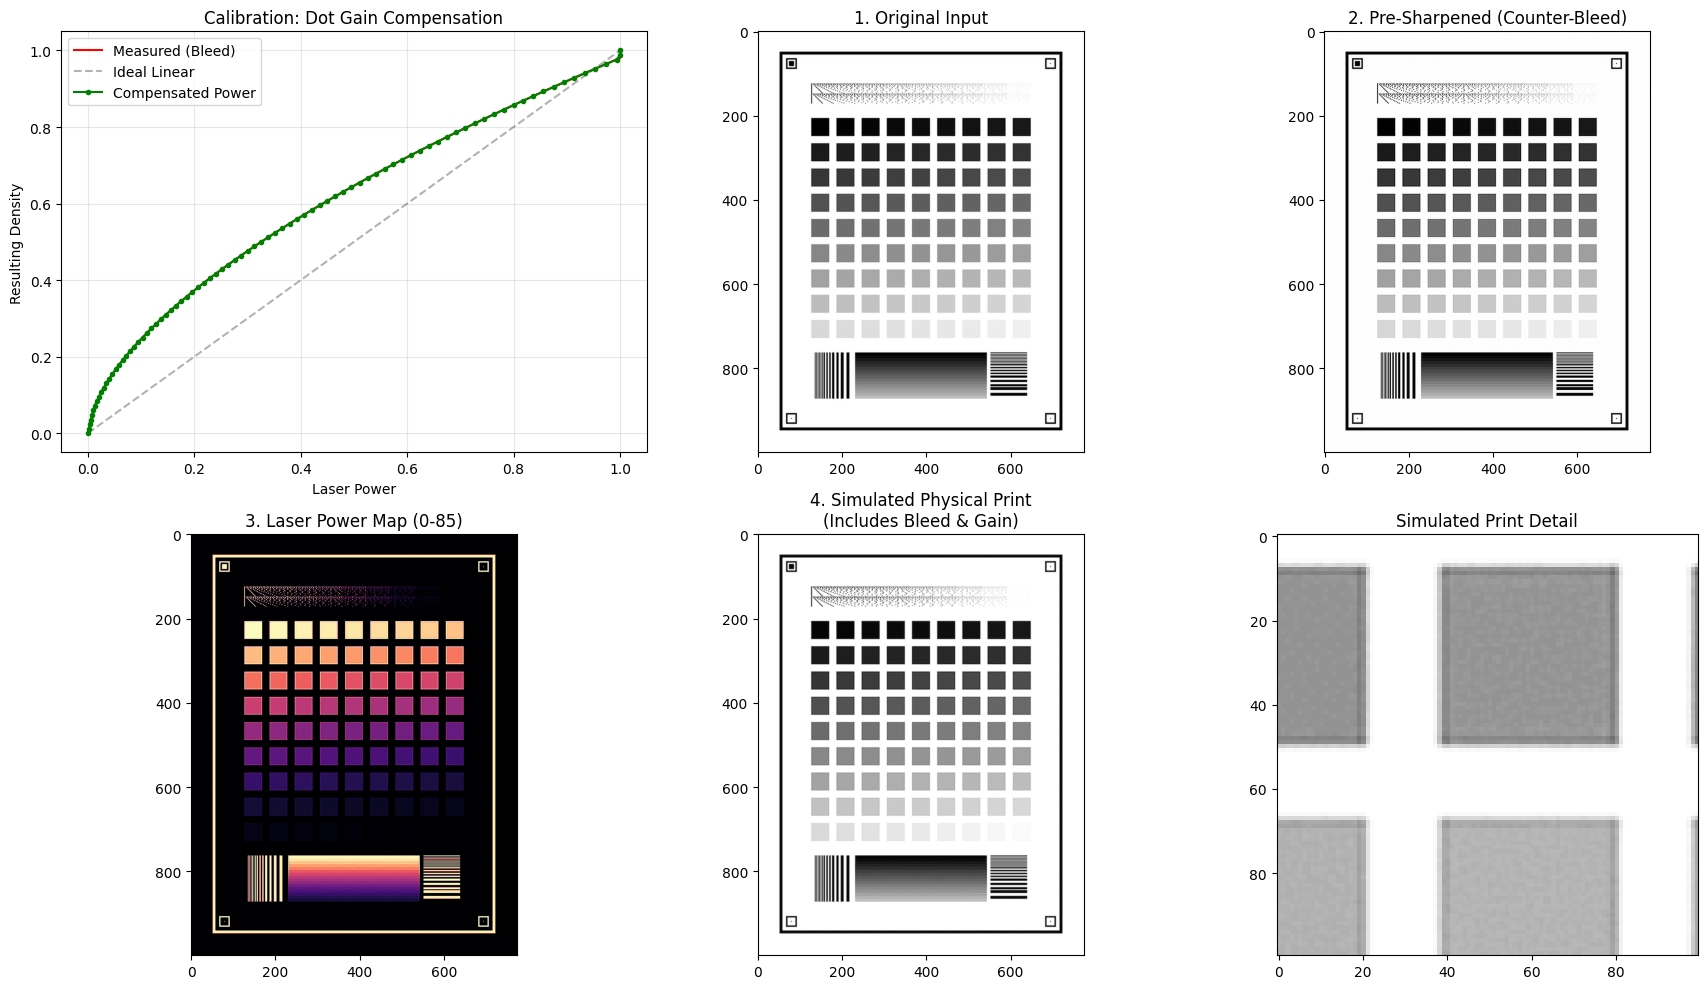

------------------------------
File saved: laser_map_inverted.png
Stats:
  Configuration Steps: 85 (0-84)
  Original Map Range:  0 to 84
  Saved PNG Range:     0 to 84
------------------------------


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import os
from scipy import interpolate

# ==========================================
# 1. Configuration
# ==========================================
# Adjust these paths as needed
INPUT_IMAGE_PATH = "calibration_target_v8.png"

# Using os.path.join for cross-platform compatibility (Windows/Mac/Linux)
# This matches your request: ..\bluenoise\128_128\LDR_LLL1_0.png
BLUE_NOISE_PATH = os.path.join('..', 'bluenoise', '128_128', 'LDR_LLL1_0.png')
LASER_STEPS = 85

# Sizing Settings
TARGET_DPI = 254
TARGET_LONGEST_EDGE_MM = 100  # Set the desired length of the longest side in mm

# ==========================================
# 2. Physics Simulation (The "Problem")
# ==========================================

def get_measured_curve(steps):
    """
    Simulates the 'Dot Gain' / Bleed effect of the UV Laser on Cyanotype.
    
    X-axis: Laser Power Index (normalized 0-1)
    Y-axis: Resulting Physical Density (0=Paper White, 1=Darkest Blue)
    
    In this simulation:
    - Low power burns disproportionately fast (high gain in highlights).
    - Mid power bleeds significantly (dot gain).
    - Max power saturates.
    """
    power_input = np.linspace(0, 1, steps)
    
    # Simulate specific UV laser/Cyanotype behavior:
    # 1. 'power_input ** 0.6' -> Mimics rapid darkening (Gamma < 1)
    # 2. Max(0.95) -> Even max power might not be 'perfect' black if under-exposed
    measured_density = (power_input ** 0.6) * 0.98
    
    return power_input, measured_density

# ==========================================
# 3. Calibration Logic (The "Solution")
# ==========================================

def generate_compensated_lut(target_steps, measured_power, measured_density):
    """
    Creates a Lookup Table that counter-acts the physical dot gain.
    
    We want a LINEAR visual result (0.0 to 1.0).
    We look at the measured_density curve and find which Power Input 
    actually resulted in that density.
    """
    # Create the ideal linear target (what we WANT to see on paper)
    desired_density = np.linspace(0, 1, target_steps)
    
    # We need to find P such that Measure(P) == Desired
    # We use interpolation to reverse map: Density -> Power
    inverse_mapper = interpolate.interp1d(
        measured_density, 
        measured_power, 
        kind='linear', 
        fill_value="extrapolate"
    )
    
    # Get the specific power levels needed to achieve linear steps
    compensated_power_levels = inverse_mapper(desired_density)
    
    # Clip to ensure we stay within 0-1 range
    return np.clip(compensated_power_levels, 0, 1)

# ==========================================
# 4. Processing Functions
# ==========================================

def resize_to_physical_dim(pil_img, longest_edge_mm, dpi):
    """
    Resizes a PIL image to specific physical dimensions at a specific DPI.
    """
    # Calculate target pixels
    # Formula: pixels = (mm / 25.4) * dpi
    target_pixels_max = int((longest_edge_mm / 25.4) * dpi)
    
    # Get current dimensions
    w, h = pil_img.size
    
    # Calculate scale maintaining aspect ratio
    if w > h:
        new_w = target_pixels_max
        new_h = int(h * (target_pixels_max / w))
    else:
        new_h = target_pixels_max
        new_w = int(w * (target_pixels_max / h))
        
    print(f"Resizing input to: {new_w}x{new_h} px ({longest_edge_mm}mm longest edge @ {dpi} DPI)")
    
    # High quality resampling
    return pil_img.resize((new_w, new_h), Image.Resampling.LANCZOS)


def pre_sharpen(img_arr, amount=1.5):
    """
    Compensates for spatial 'bleed' (blur) by pre-sharpening the input.
    """
    # Convert back to PIL for easy UnsharpMask
    img_pil = Image.fromarray((img_arr * 255).astype(np.uint8))
    
    # FIX: Cast percent to int() because PIL throws a TypeError on floats
    sharpen_val = int(100 * amount)
    
    # Radius depends on how much your laser "blooms". 
    # If the dot expands by 1 pixel, use radius ~1.
    sharpened = img_pil.filter(ImageFilter.UnsharpMask(radius=1, percent=sharpen_val, threshold=0))
    
    return np.array(sharpened).astype(np.float32) / 255.0

def multilevel_dither_compensated(img, noise, compensated_lut, spread=1):
    """
    Applies Blue Noise Dither with an optional 'spread'.
    spread=1: Dithers between adjacent levels.
    spread=5: Dithers between levels 5 steps apart.
    """
    h, w = img.shape
    
    target_density = 1.0 - img 
    
    lut_size = len(compensated_lut)
    max_idx = lut_size - 1
    
    # 1. Calculate the ideal floating point index
    idx_float = target_density * max_idx
    
    # 2. Determine the Lower bound based on Spread
    # Example: if spread=5 and idx=42.6 -> lower=40
    lower_bound = (np.floor(idx_float / spread) * spread).astype(int)
    
    # 3. Calculate fraction between "Lower" and "Lower + Spread"
    # Example: (42.6 - 40) / 5 = 0.52
    fraction = (idx_float - lower_bound) / spread
    
    # 4. Compare to Noise
    bump_up = (fraction > noise).astype(int)
    
    # 5. Select the Index
    # If bump_up is 1, we effectively jump to (lower_bound + spread)
    final_density_idx = lower_bound + (bump_up * spread)
    
    # 6. Safety Clip
    final_density_idx = np.clip(final_density_idx, 0, max_idx)
    
    # 7. Retrieve the Compensated Power Level
    final_laser_power = compensated_lut[final_density_idx]
    
    machine_steps = (final_laser_power * (LASER_STEPS - 1)).astype(int)
    
    return machine_steps

# ==========================================
# 5. Execution
# ==========================================

# A. Generate Data
raw_power, raw_density = get_measured_curve(LASER_STEPS)
compensated_lut_vals = generate_compensated_lut(LASER_STEPS, raw_power, raw_density)

# B. Load Image & Noise
print("--- Processing ---")
pil_original = Image.open(INPUT_IMAGE_PATH).convert('RGB')
pil_resized = resize_to_physical_dim(pil_original, TARGET_LONGEST_EDGE_MM, TARGET_DPI)
img_rgb = np.array(pil_resized) / 255.0
img_gray = 0.299*img_rgb[:,:,0] + 0.587*img_rgb[:,:,1] + 0.114*img_rgb[:,:,2]

# C. Pre-Correction (Spatial)
# Since the laser bleeds, we sharpen the input so the bleed brings it back to normal
img_sharpened = pre_sharpen(img_gray, amount=1.2)

# D. Load Noise
noise = np.array(Image.open(BLUE_NOISE_PATH).convert('L')) / 255.0

# Tile Noise
th, tw = img_gray.shape
nh, nw = noise.shape
noise_tiled = np.tile(noise, ((th//nh)+1, (tw//nw)+1))[:th, :tw]

# E. Run Dither
# spread=1 is default (smoothest)
# spread=4 or higher makes the dots more distinct
laser_command_map = multilevel_dither_compensated(
    img_sharpened, 
    noise_tiled, 
    compensated_lut_vals, 
    spread=4 
)


# ==========================================
# 6. Visualization (Simulating the Print)
# ==========================================

# 1. Map commands back to "Expected Physical Density" using the raw curve
# This shows what will actually appear on the paper
simulated_print_density = np.interp(
    laser_command_map / (LASER_STEPS - 1), # x-coord (commanded power 0-1)
    raw_power,                             # x-ref
    raw_density                            # y-ref (result density)
)

# 2. Simulate spatial bleed (blur) 
# This mimics the "point bleeds out" effect physically happening on paper
from scipy.ndimage import gaussian_filter
simulated_print_physical = gaussian_filter(simulated_print_density, sigma=0.6)

# Plotting
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# Top Left: The Calibration Curve
ax[0,0].plot(raw_power, raw_density, 'r-', label='Measured (Bleed)')
ax[0,0].plot(np.linspace(0,1,LASER_STEPS), np.linspace(0,1,LASER_STEPS), 'k--', alpha=0.3, label='Ideal Linear')
ax[0,0].plot(compensated_lut_vals, np.linspace(0,1,LASER_STEPS), 'g.-', label='Compensated Power')
ax[0,0].set_title("Calibration: Dot Gain Compensation")
ax[0,0].set_xlabel("Laser Power")
ax[0,0].set_ylabel("Resulting Density")
ax[0,0].legend()
ax[0,0].grid(True, alpha=0.3)

# Top Middle: Input
ax[0,1].imshow(img_gray, cmap='gray', vmin=0, vmax=1)
ax[0,1].set_title("1. Original Input")

# Top Right: Sharpened Input
ax[0,2].imshow(img_sharpened, cmap='gray', vmin=0, vmax=1)
ax[0,2].set_title("2. Pre-Sharpened (Counter-Bleed)")

# Bottom Left: The Laser Command Map (What you send to machine)
# Note: It usually looks 'lighter' than the image to account for darkening bleed
ax[1,0].imshow(laser_command_map, cmap='magma') 
ax[1,0].set_title(f"3. Laser Power Map (0-{LASER_STEPS})")

# Bottom Middle: Simulated Result
# Note: We invert cmap because in Density, 1=Dark
ax[1,1].imshow(1 - simulated_print_physical, cmap='gray', vmin=0, vmax=1)
ax[1,1].set_title("4. Simulated Physical Print\n(Includes Bleed & Gain)")

# Bottom Right: Detail Zoom
h, w = laser_command_map.shape
zoom = simulated_print_physical[h//2:h//2+100, w//2:w//2+100]
ax[1,2].imshow(1 - zoom, cmap='gray', vmin=0, vmax=1)
ax[1,2].set_title("Simulated Print Detail")

plt.tight_layout()
plt.show()

# ==========================================
# 7. Output to PNG
# ==========================================

# Define the maximum possible step index (e.g., 80 steps means indices 0-79)
max_step_index = LASER_STEPS - 1

# 1. Reverse the values
# Logic: Output = Max_Possible_Value - Current_Value
# Result: 79 becomes 0, 0 becomes 79
inverted_map = max_step_index - laser_command_map

# 2. Convert to 8-bit Unsigned Integer
# constraint: "dont scale the values"
# We simply cast the 0-79 float/int range into uint8. 
# The resulting image will look very dark on a standard monitor (values 0-79 out of 255),
# but the data values will be the exact steps required.
final_output_array = inverted_map.astype(np.uint8)

# 3. Save as Grayscale PNG
output_filename = "laser_map_inverted.png"
output_image = Image.fromarray(final_output_array, mode='L')
output_image.save(output_filename, dpi=(TARGET_DPI, TARGET_DPI))

print("-" * 30)
print(f"File saved: {output_filename}")
print(f"Stats:")
print(f"  Configuration Steps: {LASER_STEPS} (0-{max_step_index})")
print(f"  Original Map Range:  {laser_command_map.min()} to {laser_command_map.max()}")
print(f"  Saved PNG Range:     {final_output_array.min()} to {final_output_array.max()}")
print("-" * 30)

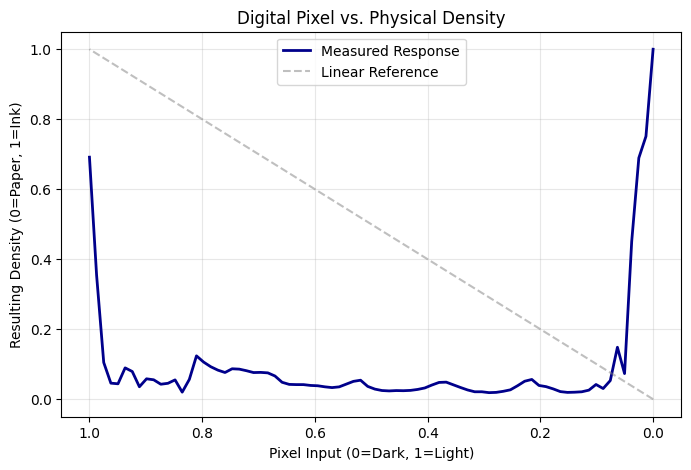

In [117]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# 1. SETUP & DATA LOADING
# ---------------------------------------------------------
# Replace 'your_data.csv' with your actual file path
df = pd.read_csv("correction_lut.csv")

# ---------------------------------------------------------

def process_and_get_interpolator(dataframe):
    """
    Normalizes CSV data and returns a callable interpolation function.
    """
    # 1. Sort by input_val to ensure interpolation works correctly
    df_sorted = dataframe.sort_values(by='input_val')
    
    x_raw = df_sorted['input_val'].values
    y_raw = df_sorted['measured_intensity'].values

    # 2. Normalize Pixel Input to 0-1
    # 0.0 = Black Pixel, 1.0 = White Pixel
    x_norm = (x_raw - x_raw.min()) / (x_raw.max() - x_raw.min())

    # 3. Normalize Measured Density to 0-1
    # 0.0 = Paper White (Minimum measured value)
    # 1.0 = Darkest Blue (Maximum measured value)
    y_norm = (y_raw - y_raw.min()) / (y_raw.max() - y_raw.min())

    # 4. Create Interpolator
    # This maps the Digital Pixel (0-1) to the Physical Density (0-1)
    return interp1d(x_norm, y_norm, kind='linear', fill_value="extrapolate")

# Initialize the interpolator globally
curve_interpolator = process_and_get_interpolator(df)

# 2. THE UPDATED FUNCTION
# ---------------------------------------------------------
def get_measured_curve(steps):
    """
    Simulates the response curve based on measured CSV data.
    
    X-axis: Digital Pixel Value (normalized 0=Black, 1=White)
    Y-axis: Resulting Print Density (0=Paper White, 1=Darkest Blue)
    """
    # Create inputs representing pixels from 0 (Black) to 1 (White)
    pixel_input = np.linspace(0, 1, steps)
    
    # Get the density that physically occurred for these pixels
    resulting_density = curve_interpolator(pixel_input)
    
    # Clip values to stay strictly within 0.0 - 1.0 range
    resulting_density = np.clip(resulting_density, 0, 1)
    
    return pixel_input, resulting_density

# 3. VERIFICATION PLOT
# ---------------------------------------------------------
pixels, density = get_measured_curve(80)

plt.figure(figsize=(8, 5))
plt.plot(pixels, density, label='Measured Response', color='darkblue', linewidth=2)
plt.plot(pixels, pixels, '--', color='gray', label='Linear Reference', alpha=0.5)

# Naming the axes as requested
plt.title("Digital Pixel vs. Physical Density")
plt.xlabel("Pixel Input (0=Dark, 1=Light)")
plt.ylabel("Resulting Density (0=Paper, 1=Ink)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis() # Optional: Visually puts Black (0) on the left
plt.show()